In [1]:
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import sys
import os
import datetime
from sknetwork.ranking import PageRank
from IPython.display import SVG
from sknetwork.visualization import svg_graph
from scipy.sparse import csr_matrix

In [2]:
from Vocab_class import TermVocab
TVocab = TermVocab()

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/harsh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
coll_dir = '20news-bydate-test'

In [5]:
class genSimGraph:
    def __init__(self, coll_dir, op_file):
        self.coll_dir = coll_dir
        self.op_file = op_file
        self.doc_term_dict = None
        self.vocab = TermVocab()
        self.limit_file_read_to = 10000
        self.file_count = 0
        self.docs_list = []
    
    def cosine_sim(self, d1, d2):
        sim = np.dot(d1, d2)/(np.linalg.norm(d1) * np.linalg.norm(d2))
        return sim
        
    def generate_term_set(self):
        limit_file_read_to = self.limit_file_read_to
        coll_dir = self.coll_dir
        doc_term_dict = {}
        print('Creating Term set for docs')
        ps = PorterStemmer()
        docs_list = []
        file_count = 0
        read_file_count = 0
        for foldername in os.listdir(coll_dir):
            print('For Folder:', foldername)
            path_to_file = os.path.join(coll_dir, foldername)
            for filename in os.listdir(path_to_file):
                file_count+=1
                #print('---------------------For File:', filename)
                #print('file:', foldername+'/'+filename,end = ' ')
                docs_list.append(foldername+'/'+filename)
                with open(os.path.join(path_to_file, filename), 'r', encoding= 'latin') as f:
                    content = None
                    try:
                        content = f.read()
                    except:
                        print('-------------cant read',foldername +'/'+filename)
                        continue
                    read_file_count +=1
                    #print(content)
                    doc_terms = word_tokenize(content)
                    #print(doc_terms)
                    stemmed_terms = [ps.stem(term) for term in doc_terms]
                    #print('non unique',len(stemmed_terms))
                    #print('uniq', len(set(stemmed_terms)))
                    doc_term_dict[foldername+'/'+filename] = set(stemmed_terms)
                    [self.vocab.add_term(term) for term in stemmed_terms]
                    #TVocab.add_term(stemmed_terms[0])
                    #print(stemmed_terms)
                if file_count>=limit_file_read_to:
                    break
            if file_count>=limit_file_read_to:
                break
        print('File count:', file_count)
        self.file_count = file_count
        print('Read File Count:', read_file_count)
        self.doc_term_dict = doc_term_dict
        self.docs_list = docs_list
        return doc_term_dict
    
    def write_to_file(self, doc1, doc2, sim, path = None):
        if path == None:
            path = self.op_file
        content = "%s\t%s\t%0.4f\n"%(doc1, doc2, sim)
        with open(path, '+a') as file:
            file.write(content)
        return True
    
    def clear_file(self, filename):
        open(filename, 'w').close()
        return True
    
    def gen_vocab(self):
        limit_file_read_to = self.limit_file_read_to
        coll_dir = self.coll_dir
        idf = {}
        self.vocab = TermVocab()
        print('Generating vocab')
        ps = PorterStemmer()
        file_count = 0
        read_file_count = 0
        for foldername in os.listdir(coll_dir):
            print('For Folder:', foldername)
            path_to_file = os.path.join(coll_dir, foldername)
            for filename in os.listdir(path_to_file):
                file_count+=1
                #print('---------------------For File:', filename)
                #print('file:', foldername+'/'+filename,end = ' ')
                with open(os.path.join(path_to_file, filename), 'r',encoding= 'latin') as f:
                    content = None
                    try:
                        content = f.read()
                    except:
                        print('cant read',foldername +'/'+filename)
                        continue
                    read_file_count +=1
                    #print(content)
                    doc_terms = word_tokenize(content)
                    #print(doc_terms)
                    stemmed_terms = set([ps.stem(term) for term in doc_terms])
                    #doc_term_dict[foldername+'/'+filename] = set(stemmed_terms)
                    for term in stemmed_terms:
                        self.vocab.add_term(term)
                        if term in idf:
                            idf[term] +=1
                        else:
                            idf[term] = 1
                    #TVocab.add_term(stemmed_terms[0])
                    #print(stemmed_terms)
                if file_count>=limit_file_read_to:
                    break
            if file_count>=limit_file_read_to:
                break
        D = file_count
        for term in idf:
            idf[term] = np.log(1 +D/idf[term])
        #print(file_count)
        self.file_count = file_count
        return idf
    
    def make_doc_vectors(self):
        limit_file_read_to = self.limit_file_read_to
        coll_dir = self.coll_dir
        docs_list = []
        tf = {}
        idf = self.gen_vocab()
        n = self.vocab.vocab_length
        print('Creating vector for docs')
        ps = PorterStemmer()
        file_count = 0
        read_file_count = 0
        for foldername in os.listdir(coll_dir):
            print('For Folder:', foldername)
            path_to_file = os.path.join(coll_dir, foldername)
            for filename in os.listdir(path_to_file):
                file_count+=1
                #print('---------------------For File:', filename)
                #print('file:', foldername+'/'+filename,end = ' ')
                docs_list.append(foldername+'/'+filename)
                with open(os.path.join(path_to_file, filename), 'r', encoding= 'latin') as f:
                    content = None
                    try:
                        content = f.read()
                    except:
                        print('cant read',foldername +'/'+filename)
                        continue
                    read_file_count +=1
                    
                    #tokenize and stem
                    doc_terms = word_tokenize(content)
                    #if len(doc_terms) < 1:
                    #    continue
                    stemmed_terms = [ps.stem(term) for term in doc_terms]
                    
                    #make tf vector for docs
                    doc_v = np.zeros(n)
                    for term in stemmed_terms:
                        doc_v[self.vocab.to_index(term)] += 1
                    doc_v = np.ma.log(doc_v)
                    tf[foldername+'/'+filename] = 1 + doc_v.filled(0)
                    
                    #include idf part in the vector
                    for term_index in range(self.vocab.vocab_length):
                        term = self.vocab.to_term(term_index)
                        tf[foldername+'/'+filename][term_index] *= idf[term]
                    
                if file_count>=limit_file_read_to:
                    break
            if file_count>=limit_file_read_to:
                break
        self.docs_list = docs_list
        print('Files Count:',file_count)
        print('Files Read :',read_file_count)
        return tf
        
    def jaccard_sim(self, file_path = None):
        doc_term_dict = self.generate_term_set()
        if file_path is None:
            file_path = self.op_file
        self.clear_file(file_path)
        n = len(doc_term_dict)
        jacob_mat = np.zeros((n,n))
        for i, itr_i in zip(doc_term_dict, range(n)):
            for j, itr_j in zip(doc_term_dict, range(n)):
                if itr_j <= itr_i:
                    continue
                term_dic_i = doc_term_dict[i]
                term_dic_j = doc_term_dict[j]
                if len(term_dic_i)>0 or len(term_dic_j)>0:
                    nr = len(term_dic_i & term_dic_j)
                    dr = len(term_dic_i | term_dic_j)
                    jacob_mat[itr_i, itr_j] = nr/dr
                    jacob_mat[itr_j, itr_i] = nr/dr
                    if jacob_mat[itr_i, itr_j] != 0:
                        self.write_to_file(i, j, jacob_mat[itr_i, itr_j], file_path)
        print(jacob_mat)
        return jacob_mat
    
    def tf_idf_sim(self, file_path = None):
        doc_vectors = self.make_doc_vectors()
        n = self.vocab.vocab_length
        m = self.file_count
        if file_path is None:
            file_path = self.op_file
        self.clear_file(file_path)
        #n = self.file_count
        print('file count:', m)
        sim_mat = np.zeros((m,m))
        #for d1, i in zip(doc_vectors, range(m)):
        #    for d2, j in zip(doc_vectors, range(m)):
        for i in range(m):
            for j in range(i+1,m):
                d1 = self.docs_list_list[i]
                d2 = self.docs_list[j]
                #if j <= i:
                #    continue
                sim = self.cosine_sim(doc_vectors[d1], doc_vectors[d2])
                sim_mat[i,j] = sim
                sim_mat[j,i] = sim
                if sim > 0:
                    self.write_to_file(d1, d2, sim, file_path)
        print(sim_mat)
        return sim_mat
    
    def show_graph(self, adj, scores, reduce_width = None):
        adj_cpy = np.array(adj)
        if reduce_width is not None:
            for i in range(adj_cpy.shape[0]):
                for j in range(adj_cpy.shape[1]):
                    if adj_cpy[i,j] >0:
                        adj_cpy[i,j] = reduce_width + np.log(adj[i,j])
        
        image = svg_graph(
            csr_matrix(adj),
            scores=scores,
            names = self.docs_list)
        return image

In [6]:
g_sim = genSimGraph(coll_dir, 'sim_op.txt')

In [7]:
jacob_sim_mat = g_sim.jaccard_sim(file_path='jacob_sim_file.txt')

Creating Term set for docs
For Folder: sci.space
For Folder: talk.politics.mideast
For Folder: talk.religion.misc
For Folder: comp.os.ms-windows.misc
For Folder: sci.med
For Folder: rec.sport.hockey
For Folder: sci.crypt
For Folder: talk.politics.guns
For Folder: rec.motorcycles
For Folder: comp.graphics
For Folder: soc.religion.christian
For Folder: comp.sys.ibm.pc.hardware
For Folder: misc.forsale
For Folder: rec.sport.baseball
For Folder: comp.windows.x
For Folder: alt.atheism
For Folder: rec.autos
For Folder: talk.politics.misc
For Folder: sci.electronics
For Folder: comp.sys.mac.hardware
File count: 7532
Read File Count: 7532
[[0.         0.20178042 0.18181818 ... 0.18302387 0.12080537 0.09056604]
 [0.20178042 0.         0.17567568 ... 0.15506329 0.12444444 0.10638298]
 [0.18181818 0.17567568 0.         ... 0.19325153 0.12601626 0.08920188]
 ...
 [0.18302387 0.15506329 0.19325153 ... 0.         0.1221374  0.09210526]
 [0.12080537 0.12444444 0.12601626 ... 0.1221374  0.         0.1

In [8]:
pagerank1 = PageRank(damping_factor=0.85)
scores1 = pagerank1.fit_transform(jacob_sim_mat)
print('scores-\n\t:',scores1)
#img = g_sim.show_graph(np.ones_like(jacob_sim_mat), scores1,1)
#SVG(img)

scores-
	: [0.00014609 0.00014101 0.0001434  ... 0.00014178 0.00013563 0.00011892]


In [9]:
ti_sim_mat = g_sim.tf_idf_sim(file_path='tf_idf_sim_file.txt')

Generating vocab
For Folder: sci.space
For Folder: talk.politics.mideast
For Folder: talk.religion.misc
For Folder: comp.os.ms-windows.misc
For Folder: sci.med
For Folder: rec.sport.hockey
For Folder: sci.crypt
For Folder: talk.politics.guns
For Folder: rec.motorcycles
For Folder: comp.graphics
For Folder: soc.religion.christian
For Folder: comp.sys.ibm.pc.hardware
For Folder: misc.forsale
For Folder: rec.sport.baseball
For Folder: comp.windows.x
For Folder: alt.atheism
For Folder: rec.autos
For Folder: talk.politics.misc
For Folder: sci.electronics
For Folder: comp.sys.mac.hardware
Creating vector for docs
For Folder: sci.space
For Folder: talk.politics.mideast
For Folder: talk.religion.misc
For Folder: comp.os.ms-windows.misc
For Folder: sci.med
For Folder: rec.sport.hockey
For Folder: sci.crypt
For Folder: talk.politics.guns
For Folder: rec.motorcycles
For Folder: comp.graphics
For Folder: soc.religion.christian
For Folder: comp.sys.ibm.pc.hardware
For Folder: misc.forsale
For Folde

In [10]:
pagerank2 = PageRank(damping_factor=0.85)
scores2 = pagerank2.fit_transform(ti_sim_mat)
print('scores-\n\t:',scores2)
#img = g_sim.show_graph(ti_sim_mat, np.log(scores2),reduce_width=1)
#SVG(img)

scores-
	: [0.00013277 0.00013277 0.00013277 ... 0.00013277 0.00013277 0.00013277]


In [14]:
top_20 = np.argsort(scores2)[:20]
t2 = np.array(g_sim.docs_list)[top_20]
print(t2)
print(scores2[top_20])

['comp.os.ms-windows.misc/10140' 'comp.windows.x/68012' 'sci.space/61435'
 'comp.graphics/38851' 'comp.windows.x/67988' 'comp.windows.x/67462'
 'comp.windows.x/67882' 'talk.religion.misc/84286' 'comp.windows.x/67987'
 'talk.politics.mideast/76479' 'comp.graphics/38853' 'comp.graphics/39078'
 'comp.graphics/39638' 'sci.med/59283' 'comp.sys.mac.hardware/52004'
 'comp.graphics/38852' 'talk.politics.mideast/77257' 'sci.med/59285'
 'comp.graphics/38778' 'sci.space/61253']
[0.00013139 0.00013243 0.00013244 0.00013245 0.00013246 0.00013248
 0.00013248 0.00013251 0.00013251 0.00013252 0.00013252 0.00013253
 0.00013253 0.00013254 0.00013256 0.00013257 0.00013258 0.00013259
 0.00013259 0.0001326 ]


In [15]:
top_20 = np.argsort(scores1)[:20]
t1 = np.array(g_sim.docs_list)[top_20]
print(t1)
print(scores1[top_20])

['comp.os.ms-windows.misc/10140' 'comp.windows.x/67988'
 'comp.windows.x/67987' 'rec.sport.hockey/54168' 'rec.sport.hockey/54205'
 'rec.sport.hockey/54538' 'comp.graphics/38851' 'rec.sport.hockey/54169'
 'comp.graphics/38853' 'sci.med/59574' 'rec.sport.hockey/54478'
 'comp.graphics/38852' 'sci.space/61435' 'comp.windows.x/68012'
 'sci.med/59285' 'rec.sport.hockey/53943' 'alt.atheism/53806'
 'rec.sport.hockey/54516' 'comp.windows.x/67882'
 'rec.sport.baseball/105108']
[2.26723099e-05 2.49488413e-05 2.70599628e-05 3.97940139e-05
 4.69058909e-05 4.74716943e-05 4.87818934e-05 5.19611066e-05
 5.27712550e-05 5.41476607e-05 5.48563184e-05 5.51077606e-05
 5.64311939e-05 5.71489272e-05 5.78474990e-05 5.83283428e-05
 5.93790103e-05 5.99703584e-05 6.02264880e-05 6.05336942e-05]


In [13]:
set(t1) & set(t2)

{'comp.graphics/38851',
 'comp.graphics/38852',
 'comp.graphics/38853',
 'comp.os.ms-windows.misc/10140',
 'comp.windows.x/67882',
 'comp.windows.x/67987',
 'comp.windows.x/67988',
 'comp.windows.x/68012',
 'sci.med/59285',
 'sci.space/61435'}

In [190]:
positions = np.array([list(g_sim.doc_term_dict.keys()),(range(len(g_sim.doc_term_dict.keys())))])

In [191]:
print(positions, positions.shape)

[['sci.space/61444' 'sci.space/61440' 'sci.space/61396' 'sci.space/61363'
  'sci.space/61321' 'sci.space/61414' 'sci.space/62114']
 ['0' '1' '2' '3' '4' '5' '6']] (2, 7)


In [235]:
pagerank1 = PageRank(damping_factor=0.85)
scores1 = pagerank1.fit_transform(ti_sim_mat)
print(scores1)

[0.14161755 0.14316572 0.14145637 0.14360726 0.14280346 0.14374115
 0.14360849]


In [236]:
pagerank2 = PageRank(damping_factor=0.85)
scores2 = pagerank2.fit_transform(jacob_sim_mat)
print(scores2)

[0.15653331 0.15104661 0.15052934 0.16016858 0.11359918 0.14485192
 0.12327105]


[0.12563023 0.14717404 0.12339306 0.15329984 0.14205529 0.15515217
 0.15329537]


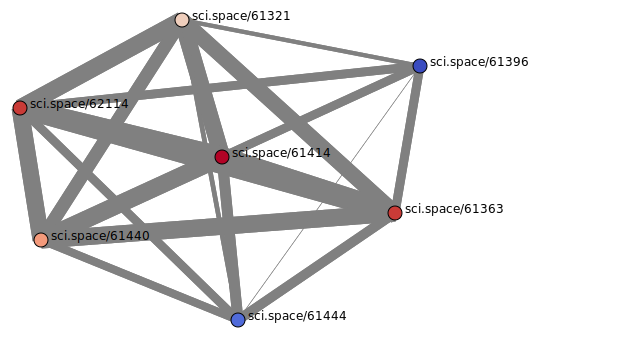

In [242]:
from scipy.sparse import csr_matrix
ti_sim_mat_cpy = np.zeros_like(ti_sim_mat)
for i in range(ti_sim_mat.shape[0]):
    for j in range(ti_sim_mat.shape[1]):
        if ti_sim_mat[i,j] >0:
            ti_sim_mat_cpy[i,j] = 0.1+ np.log(ti_sim_mat[i,j])
pr = PageRank()
sc = pr.fit_transform(ti_sim_mat_cpy)
print(sc)

image = svg_graph(csr_matrix(ti_sim_mat_cpy), scores=np.log2(scores1), names = list(g_sim.doc_term_dict.keys()))
SVG(image)

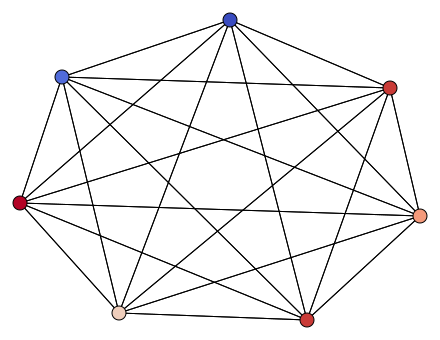

In [201]:
image = svg_graph(csr_matrix(np.ones_like(ti_sim_mat)), scores=np.log2(scores))
SVG(image)

In [152]:
from sknetwork.data import karate_club
graph = karate_club(metadata=True)
adjacency = graph.adjacency
position = graph.position

In [160]:
print(adjacency.shape)
# for i in range(34):
#     for j in range(34):
#         print(i,j, end = ' ')
#         print(adjacency[i,j])
print(adjacency.toarray())

(34, 34)
[[False  True  True ...  True False False]
 [ True False  True ... False False False]
 [ True  True False ... False  True False]
 ...
 [ True False False ... False  True  True]
 [False False  True ...  True False  True]
 [False False False ...  True  True False]]


In [153]:
print(position)

[[ 0.04 -0.33]
 [ 0.24 -0.15]
 [ 0.01 -0.01]
 [ 0.13 -0.28]
 [ 0.02 -0.64]
 [-0.08 -0.75]
 [ 0.04 -0.76]
 [ 0.21 -0.25]
 [ 0.08  0.09]
 [-0.11  0.23]
 [-0.13 -0.62]
 [-0.28 -0.4 ]
 [ 0.2  -0.53]
 [ 0.08 -0.07]
 [ 0.23  0.55]
 [ 0.06  0.64]
 [-0.06 -1.  ]
 [ 0.32 -0.42]
 [ 0.15  0.6 ]
 [ 0.19 -0.01]
 [ 0.27  0.45]
 [ 0.39 -0.34]
 [-0.04  0.61]
 [-0.26  0.41]
 [-0.51  0.14]
 [-0.49  0.28]
 [-0.19  0.68]
 [-0.28  0.21]
 [-0.11  0.12]
 [-0.17  0.54]
 [ 0.22  0.19]
 [-0.21  0.09]
 [ 0.03  0.38]
 [ 0.    0.33]]
